In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from scipy import stats
from scipy.stats import linregress
from collections import Counter
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

blue, red, green, grey ='#336699', '#9A3334', '#048004', '#AAAAAA'


listing_attributes = ['ListingKey', 'AmountRequested', 'Duration', 'BidCount', 'MeanLenderBidAmount',
                      'LenderMedianAge', 'LenderExperience',
                      'ProsperScore', 'CreditGrade', 'DebtToIncomeRatio', 
                      'IsBorrowerHomeowner', 'DescriptionLength', 'Category',  'RepaidOrNot']

herding_attributes = ['ListingKey', 'CoH1', 'CoH3', 'CoH5']

lender_attributes = ['ProjectID', 'CovInterEventTime', 'CovContributionAmount']

final_attributes = ['ProjectID', 'AmountRequested', 'Duration', 'NumBids', 'AvgBid', # Amounts
                    'LenderMedianAge', 'LenderExperience',
                    'Momentum', 'Variation', 'CoH1', 'CoH3', 'CoH5',# Momentum & Herding
                    'ProsperScore', 'CreditGrade', 'DebtRatio', 'Homeowner', # Creditworthiness
                    'Description', 'Category',  'RepaidOrNot'] # Project

creditmap = {'AA':8, 'AB':7, 'B':6, 'C':5, 'D':4, 'E':3, 'HR':2, 'NC':1, '':0}

credit_grades = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR']

coh = 'CoH5'

__author__ = 'HK Dambanemuya'
__version__ = 'Python 3'


Bad key text.latex.preview in file /usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when

In [2]:
def make_pos(value): return abs(value)
def accuracy(y_true,y_pred): return metrics.accuracy_score(y_true, y_pred)
def precision(y_true, y_pred): return metrics.precision_score(y_true, y_pred)
def recall(y_true, y_pred): return metrics.recall_score(y_true, y_pred)
def f1(y_true, y_pred): return metrics.f1_score(y_true, y_pred)
def auc(y_true, y_pred): return metrics.roc_auc_score(y_true, y_pred)
def dof(sample1, sample2):
    n1, n2, s1, s2 = len(sample1), len(sample2), np.var(sample1), np.var(sample2)
    return np.true_divide((np.true_divide(s1,n1) + np.true_divide(s2,n2))**2,
                           np.true_divide(np.true_divide(s1,n1)**2, n1-1) + 
                           np.true_divide(np.true_divide(s2,n2)**2, n2-1))
scaler = MinMaxScaler()

In [3]:
# Listing Data
listing_df = pd.read_csv('../../Data/prosper_final.csv')
listing_df = listing_df[listing_attributes]
listing_df.rename(columns={'ListingKey':'ProjectID', 
                           'BidCount': 'NumBids',
                           'MeanLenderBidAmount': 'AvgBid',
                           'DebtToIncomeRatio': 'DebtRatio',
                           'DescriptionLength': 'Description',
                           'IsBorrowerHomeowner': 'Homeowner',
                          }, inplace=True)
listing_df.head()

,ProjectID,AmountRequested,Duration,NumBids,AvgBid,LenderMedianAge,LenderExperience,ProsperScore,CreditGrade,DebtRatio,Homeowner,Description,Category,RepaidOrNot
0,00033425227988088FA6752,1000.000,7,15,66.737,256.000,1.549,6.000,3,0.190,0,190,4,1
1,7B343428727859426204CF7,2200.000,7,14,158.817,206.000,1.400,5.000,3,0.190,0,383,3,1
2,000433785890431972B4743,2550.000,10,30,85.000,57.500,1.502,-1.000,2,0.100,0,577,0,0
3,00083422661625108817246,3500.000,7,141,65.022,152.000,1.614,9.000,6,0.350,0,210,1,1
4,000A34209897973969CFA81,1500.000,7,2,775.000,296.500,1.463,7.000,2,0.040,0,134,4,1


In [4]:
# Lender Data
lender_df = pd.read_csv('../../Data/momentum_variation_data.csv')
lender_df.rename(columns={'CovInterEventTime': 'Momentum', 
                           'CovContributionAmount': 'Variation'
                          }, inplace=True)
lender_df.head()

,ProjectID,Momentum,Variation
0,00003383856420083050622,0.000,0.000
1,00003405662222292C12B86,nan,0.000
2,000034203787284229CBEF1,0.000,0.333
3,00003423466422120D65CA3,1.713,0.958
4,00013406788490687C1BB75,nan,0.000


In [5]:
# Herding Data
herding_df = pd.read_csv('../../Data/herding_data.csv')
herding_df.rename(columns={'ListingKey':'ProjectID',
                          }, inplace=True)
herding_df = herding_df[herding_df['CoH5']!=-2]
herding_df.head()

,ProjectID,CoH1,CoH3,CoH5
0,D6473365888221963456102,-0.275,-0.125,-0.096
1,601833660859080305A2AC3,0.093,0.166,0.158
2,73AB3364393429683903176,0.111,0.135,0.126
3,9AF5336547891402212A6FC,-0.048,-0.029,-0.020
4,510133648179460628B9387,0.048,0.014,0.007


In [6]:
# Herding Data
herding_df = pd.read_csv('../../Data/herding_data.csv')
herding_df.rename(columns={'ListingKey':'ProjectID',
                          }, inplace=True)
herding_df = herding_df[herding_df['CoH5']!=-2]
herding_df.head()

,ProjectID,CoH1,CoH3,CoH5
0,D6473365888221963456102,-0.275,-0.125,-0.096
1,601833660859080305A2AC3,0.093,0.166,0.158
2,73AB3364393429683903176,0.111,0.135,0.126
3,9AF5336547891402212A6FC,-0.048,-0.029,-0.020
4,510133648179460628B9387,0.048,0.014,0.007


In [7]:
herding_df.describe()

,CoH1,CoH3,CoH5
count,32897.000,32851.000,32628.000
mean,0.016,0.005,-0.000
std,0.143,0.091,0.071
min,-0.954,-0.333,-0.200
25%,-0.058,-0.041,-0.037
50%,-0.007,-0.004,-0.005
75%,0.066,0.041,0.030
max,1.000,0.910,0.808


In [8]:
data = herding_df.merge(lender_df, on='ProjectID', how='left')
data = data.merge(listing_df, on='ProjectID', how='left')
data = data[final_attributes].fillna(0)
data.head()

,ProjectID,AmountRequested,Duration,NumBids,AvgBid,LenderMedianAge,LenderExperience,Momentum,Variation,CoH1,CoH3,CoH5,ProsperScore,CreditGrade,DebtRatio,Homeowner,Description,Category,RepaidOrNot
0,D6473365888221963456102,2500.000,7.000,22.000,117.955,99.000,1.060,1.379,0.917,-0.275,-0.125,-0.096,-1.000,2.000,0.077,-1.000,262.000,0.000,1.000
1,601833660859080305A2AC3,3000.000,7.000,52.000,141.077,14.000,1.253,1.317,1.034,0.093,0.166,0.158,-1.000,8.000,0.022,-1.000,48.000,0.000,1.000
2,73AB3364393429683903176,5000.000,10.000,63.000,213.429,12.000,1.377,1.001,1.510,0.111,0.135,0.126,-1.000,8.000,0.111,-1.000,254.000,0.000,1.000
3,9AF5336547891402212A6FC,14500.000,10.000,133.000,116.594,33.000,1.237,1.300,1.009,-0.048,-0.029,-0.020,-1.000,7.000,0.180,-1.000,181.000,0.000,1.000
4,510133648179460628B9387,20000.000,10.000,257.000,198.949,65.000,1.450,1.842,2.336,0.048,0.014,0.007,-1.000,7.000,0.260,1.000,271.000,0.000,0.000


In [9]:
print ("Total Amount Allocated = ${0}".format(listing_df['AmountRequested'].sum()))
print ("Total Amount Defaulted = ${0}".format(listing_df[listing_df['RepaidOrNot']==0]['AmountRequested'].sum()))
print ("Percent Defaulted = {}%".format(round(np.true_divide(listing_df[listing_df['RepaidOrNot']==0]['AmountRequested'].sum(),
                                                       listing_df['AmountRequested'].sum()),3)*100))

Total Amount Allocated = $178556824.07999998
Total Amount Defaulted = $69877986.56
Percent Defaulted = 39.1%


In [10]:
# Loan Information
for col in ['AmountRequested', 'Duration', 'Description']:
    result = stats.spearmanr(data[col], data['CoH1'])
    print(f"{col}: r={result[0]:.3f}, p={result[1]:.3f}")
    result = stats.spearmanr(data[col], data['CoH3'])
    print(f"{col}: r={result[0]:.3f}, p={result[1]:.3f}")
    result = stats.spearmanr(data[col], data['CoH5'])
    print(f"{col}: r={result[0]:.3f}, p={result[1]:.3f}")


AmountRequested: r=0.111, p=0.000
AmountRequested: r=0.144, p=0.000
AmountRequested: r=0.178, p=0.000
Duration: r=-0.010, p=0.063
Duration: r=-0.010, p=0.058
Duration: r=-0.006, p=0.282
Description: r=-0.000, p=0.979
Description: r=0.002, p=0.684
Description: r=0.003, p=0.567


In [11]:
result = stats.pointbiserialr(data['Homeowner'], data['CoH1'])
print(f"Homeowner: r={result[0]:.3f}, p={result[1]:.3f}")
result = stats.pointbiserialr(data['Homeowner'], data['CoH3'])
print(f"Homeowner: r={result[0]:.3f}, p={result[1]:.3f}")
result = stats.pointbiserialr(data['Homeowner'], data['CoH5'])
print(f"Homeowner: r={result[0]:.3f}, p={result[1]:.3f}")

result = stats.pearsonr(data['DebtRatio'], data['CoH1'])
print(f"DebtRatio: r={result[0]:.3f}, p={result[1]:.3f}")
result = stats.pearsonr(data['DebtRatio'], data['CoH3'])
print(f"DebtRatio: r={result[0]:.3f}, p={result[1]:.3f}")
result = stats.pearsonr(data['DebtRatio'], data['CoH5'])
print(f"DebtRatio: r={result[0]:.3f}, p={result[1]:.3f}")

result = stats.spearmanr(data['CreditGrade'], data['CoH1'])
print(f"CreditGrade: r={result[0]:.3f}, p={result[1]:.3f}")
result = stats.spearmanr(data['CreditGrade'], data['CoH3'])
print(f"CreditGrade: r={result[0]:.3f}, p={result[1]:.3f}")
result = stats.spearmanr(data['CreditGrade'], data['CoH5'])
print(f"CreditGrade: r={result[0]:.3f}, p={result[1]:.3f}")

result = stats.spearmanr(data['ProsperScore'], data['CoH1'])
print(f"ProsperScore: r={result[0]:.3f}, p={result[1]:.3f}")
result = stats.spearmanr(data['ProsperScore'], data['CoH3'])
print(f"ProsperScore: r={result[0]:.3f}, p={result[1]:.3f}")
result = stats.spearmanr(data['ProsperScore'], data['CoH5'])
print(f"ProsperScore: r={result[0]:.3f}, p={result[1]:.3f}")

Homeowner: r=-0.001, p=0.802
Homeowner: r=0.020, p=0.000
Homeowner: r=0.032, p=0.000
DebtRatio: r=0.021, p=0.000
DebtRatio: r=0.019, p=0.001
DebtRatio: r=0.013, p=0.015
CreditGrade: r=0.053, p=0.000
CreditGrade: r=0.074, p=0.000
CreditGrade: r=0.097, p=0.000
ProsperScore: r=0.042, p=0.000
ProsperScore: r=0.072, p=0.000
ProsperScore: r=0.092, p=0.000


In [12]:
# Borrower Information
var = data[data.DebtRatio<=1]
var = var[var.CreditGrade>2]
# var = var[var.ProsperScore>0]

for col in ['Homeowner', 'DebtRatio', 'CreditGrade', 'ProsperScore']:
#     if col=='DebtRatio':
#         var = data[data.DebtRatio<=1]
#         result = stats.spearmanr(var[col], var['CoH5'])
#     if col=='CreditGrade':
#         var = data[data.CreditGrade>2]
#         result = stats.spearmanr(var[col], var['CoH5'])
#     if col=='ProsperScore':
#         var = data[data.ProsperScore>0]
#         result = stats.spearmanr(var[col], var['CoH5'])
#     if col=='Homeowner':
    result = stats.spearmanr(var[col], var['CoH5'])
    print(f"{col}: r={result[0]:.3f}, p={result[1]:.3f}")

Homeowner: r=0.052, p=0.000
DebtRatio: r=0.069, p=0.000
CreditGrade: r=0.125, p=0.000
ProsperScore: r=0.083, p=0.000


In [13]:
# Lending Dynamics
for col in ['NumBids', 'Momentum', 'Variation']:
    result = stats.pearsonr(data[col], data['CoH1'])
    print(f"{col}: r={result[0]:.3f}, p={result[1]:.3f}")
    result = stats.pearsonr(data[col], data['CoH3'])
    print(f"{col}: r={result[0]:.3f}, p={result[1]:.3f}")
    result = stats.pearsonr(data[col], data['CoH5'])
    print(f"{col}: r={result[0]:.3f}, p={result[1]:.3f}")

NumBids: r=0.057, p=0.000
NumBids: r=0.121, p=0.000
NumBids: r=0.164, p=0.000
Momentum: r=0.020, p=0.000
Momentum: r=0.052, p=0.000
Momentum: r=0.076, p=0.000
Variation: r=-0.005, p=0.336
Variation: r=-0.027, p=0.000
Variation: r=-0.029, p=0.000


In [14]:
# Lender Characteristics
for col in ['LenderMedianAge', 'LenderExperience']:
    result = stats.pearsonr(data[col], data['CoH1'])
    print(f"{col}: r={result[0]:.3f}, p={result[1]:.3f}")
    result = stats.pearsonr(data[col], data['CoH3'])
    print(f"{col}: r={result[0]:.3f}, p={result[1]:.3f}")
    result = stats.pearsonr(data[col], data['CoH5'])
    print(f"{col}: r={result[0]:.3f}, p={result[1]:.3f}")

LenderMedianAge: r=-0.003, p=0.548
LenderMedianAge: r=-0.000, p=0.948
LenderMedianAge: r=0.008, p=0.148
LenderExperience: r=-0.029, p=0.000
LenderExperience: r=-0.040, p=0.000
LenderExperience: r=-0.038, p=0.000


In [15]:
stats.pearsonr(data['LenderMedianAge'], data['LenderExperience'])

(0.5529944005762739, 0.0)

In [16]:
var = data[data.DebtRatio<=1]
var = var[var.CreditGrade>2]
stats.spearmanr(var['DebtRatio'], var['CreditGrade'])

SpearmanrResult(correlation=-0.07172258123727546, pvalue=3.23374808204565e-29)

In [21]:
data['DebtRatio'].describe()

count   32907.000
mean    0.271    
std     0.852    
min     0.000    
25%     0.070    
50%     0.180    
75%     0.270    
max     10.010   
Name: DebtRatio, dtype: float64

## Herding by Loan Category

Counter({0.0: 21246, 1.0: 4915, 4.0: 2323, 3.0: 1841, 7.0: 1200, 2.0: 616, 5.0: 455, 6.0: 311}) 

           CoH5            
           mean   std   var
Category                   
0.000    -0.003 0.073 0.005
1.000    0.005  0.064 0.004
2.000    0.006  0.063 0.004
3.000    0.010  0.056 0.003
4.000    0.000  0.072 0.005
5.000    0.001  0.069 0.005
6.000    0.011  0.073 0.005
7.000    -0.001 0.072 0.005


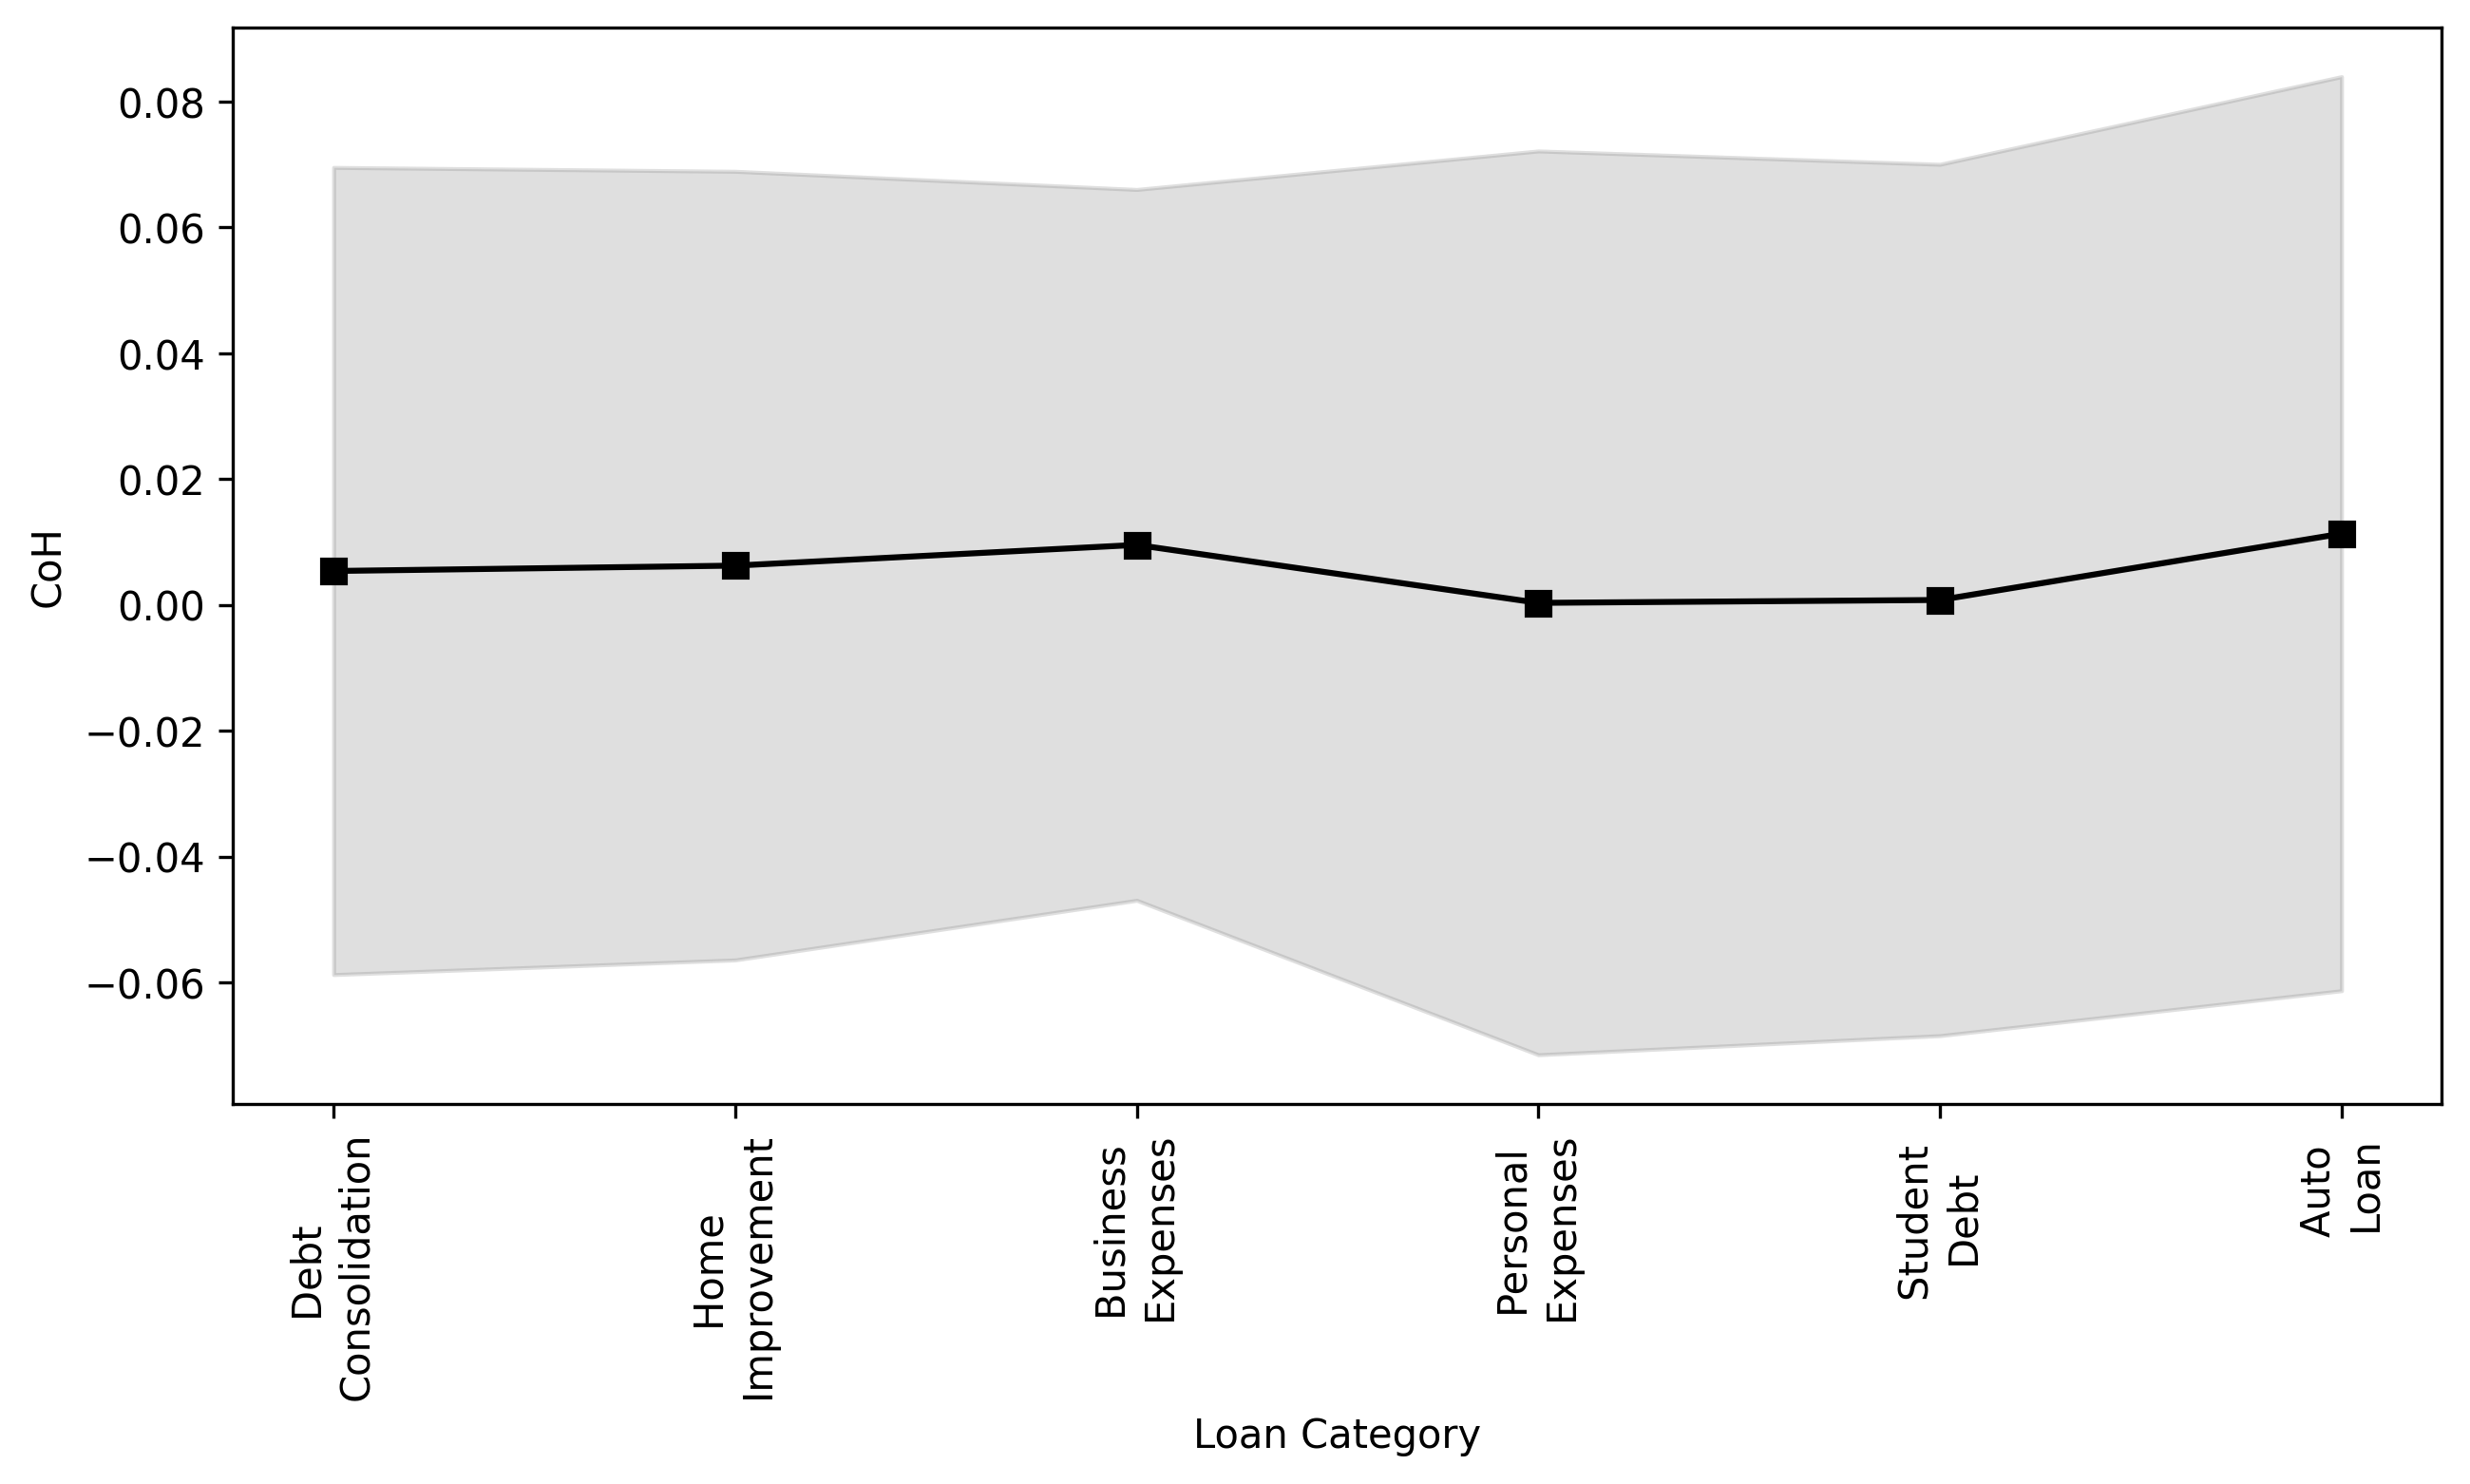

In [23]:
print (Counter(data['Category']), '\n')
print (data[[coh,'Category']].groupby('Category').agg(['mean', 'std', 'var']))

labels = ["Debt \nConsolidation", "Home \nImprovement", "Business \nExpenses", "Personal \nExpenses", "Student \nDebt", "Auto \nLoan"]

xdata = data[[coh,'Category']].groupby('Category').agg(['mean', 'std']).index.values[1:-1]
ydata = data[[coh,'Category']].groupby('Category').agg(['mean', 'std'])[(coh, 'mean')].values[1:-1]
zdata = data[[coh,'Category']].groupby('Category').agg(['mean', 'std', 'var'])[(coh, 'var')].values[1:-1]

dyfit = data[[coh,'Category']].groupby('Category').agg(['mean', 'std'])[(coh, 'std')].values[1:-1]


fig, ax = plt.subplots(figsize=(10,5), dpi=300)

ax.plot(xdata, ydata, '-', color='black')
ax.plot(xdata, ydata, 's', color='black')
ax.fill_between(xdata, ydata - dyfit, ydata + dyfit, color='grey', alpha=.25)
ax.set_ylabel('CoH')
ax.set_xlabel('Loan Category')
# ax1.set_yticks(np.arange(.4, .9, .05))

# ax2.plot(xdata, zdata, '-', color='#C0C0C0')
# ax2.plot(xdata, zdata, 'o', color='#8A2BE2')
# ax2.set_ylabel('Variation in Coef. of Herding')
# ax2.set_yticks(np.arange(0, .06, .01))

plt.xticks(xdata,labels,rotation=90)
plt.show()

In [24]:
stats.spearmanr(data.Category, data.CoH5)

SpearmanrResult(correlation=0.05883355514927824, pvalue=1.2435119278325123e-26)

## Herding by Credit Grade

In [9]:
data.head()

,ProjectID,AmountRequested,NumBids,AvgBid,Momentum,Variation,CoH1,CoH3,CoH5,ProsperScore,CreditGrade,DebtRatio,Homeowner,Description,Category,RepaidOrNot
0,D6473365888221963456102,2500.000,22.000,117.955,1.379,0.917,0.275,0.125,0.096,-1.000,2.000,0.077,-1.000,262.000,0.000,1.000
1,601833660859080305A2AC3,3000.000,52.000,141.077,1.317,1.034,0.093,0.166,0.158,-1.000,8.000,0.022,-1.000,48.000,0.000,1.000
2,73AB3364393429683903176,5000.000,63.000,213.429,1.001,1.510,0.111,0.135,0.126,-1.000,8.000,0.111,-1.000,254.000,0.000,1.000
3,9AF5336547891402212A6FC,14500.000,133.000,116.594,1.300,1.009,0.048,0.029,0.020,-1.000,7.000,0.180,-1.000,181.000,0.000,1.000
4,510133648179460628B9387,20000.000,257.000,198.949,1.842,2.336,0.048,0.014,0.007,-1.000,7.000,0.260,1.000,271.000,0.000,0.000


In [22]:
# plt.figure(figsize=(10,5), dpi=300)
# sns.lineplot(x='CreditGrade', y='CoH1', data=data, c=red, label='CoH1', legend=False)
# sns.lineplot(x='CreditGrade', y='CoH3', data=data, c=blue, label='CoH3', legend=False)
# sns.lineplot(x='CreditGrade', y='CoH5', data=data, c=green, label='CoH5', legend=False)
# plt.xticks(range(2,9), credit_grades[::-1])
# plt.xlim(8,2)
# plt.legend(loc='upper right')
# plt.ylabel('Coefficient of Herding')
# plt.xlabel('Credit Grade')
# plt.show()

## Herding, Momentum & Default by Credit Grade

In [75]:
mv_table = data[['CreditGrade', 'Momentum', 'Variation', 'CoH5']].groupby('CreditGrade').agg(['mean','std']).reset_index()
mv_table['CreditGrade'] = mv_table['CreditGrade'].astype(int)
mv_table = mv_table.replace({"CreditGrade": {value:key for key, value in creditmap.items()}}) 
mv_table = mv_table.sort_values(by='CreditGrade')[1:8]
mv_table

CreditGrade Momentum       Variation         CoH5      
                  mean   std      mean   std   mean   std
8  AA         1.951    0.830 1.010     0.654 0.006  0.060
7  AB         2.036    0.739 1.014     0.619 0.008  0.058
6  B          2.130    0.791 0.973     0.631 0.008  0.056
5  C          2.044    0.803 0.910     0.569 0.002  0.065
4  D          1.949    0.798 0.907     0.572 -0.003 0.073
3  E          1.702    0.527 0.953     0.523 -0.013 0.083
2  HR         1.559    0.539 0.960     0.500 -0.021 0.097

In [76]:
total = len(data[data['CreditGrade']>1])
total

27879

In [77]:
for k,v in Counter(data[data['CreditGrade']>1]['CreditGrade']).items():
    print (k, (v/total)*100)

2.0 10.9652426557624
8.0 12.507622224613508
7.0 11.797410237096022
3.0 11.097959037268195
4.0 18.020732450948742
5.0 19.993543527386205
6.0 15.617489866924924


### Herding

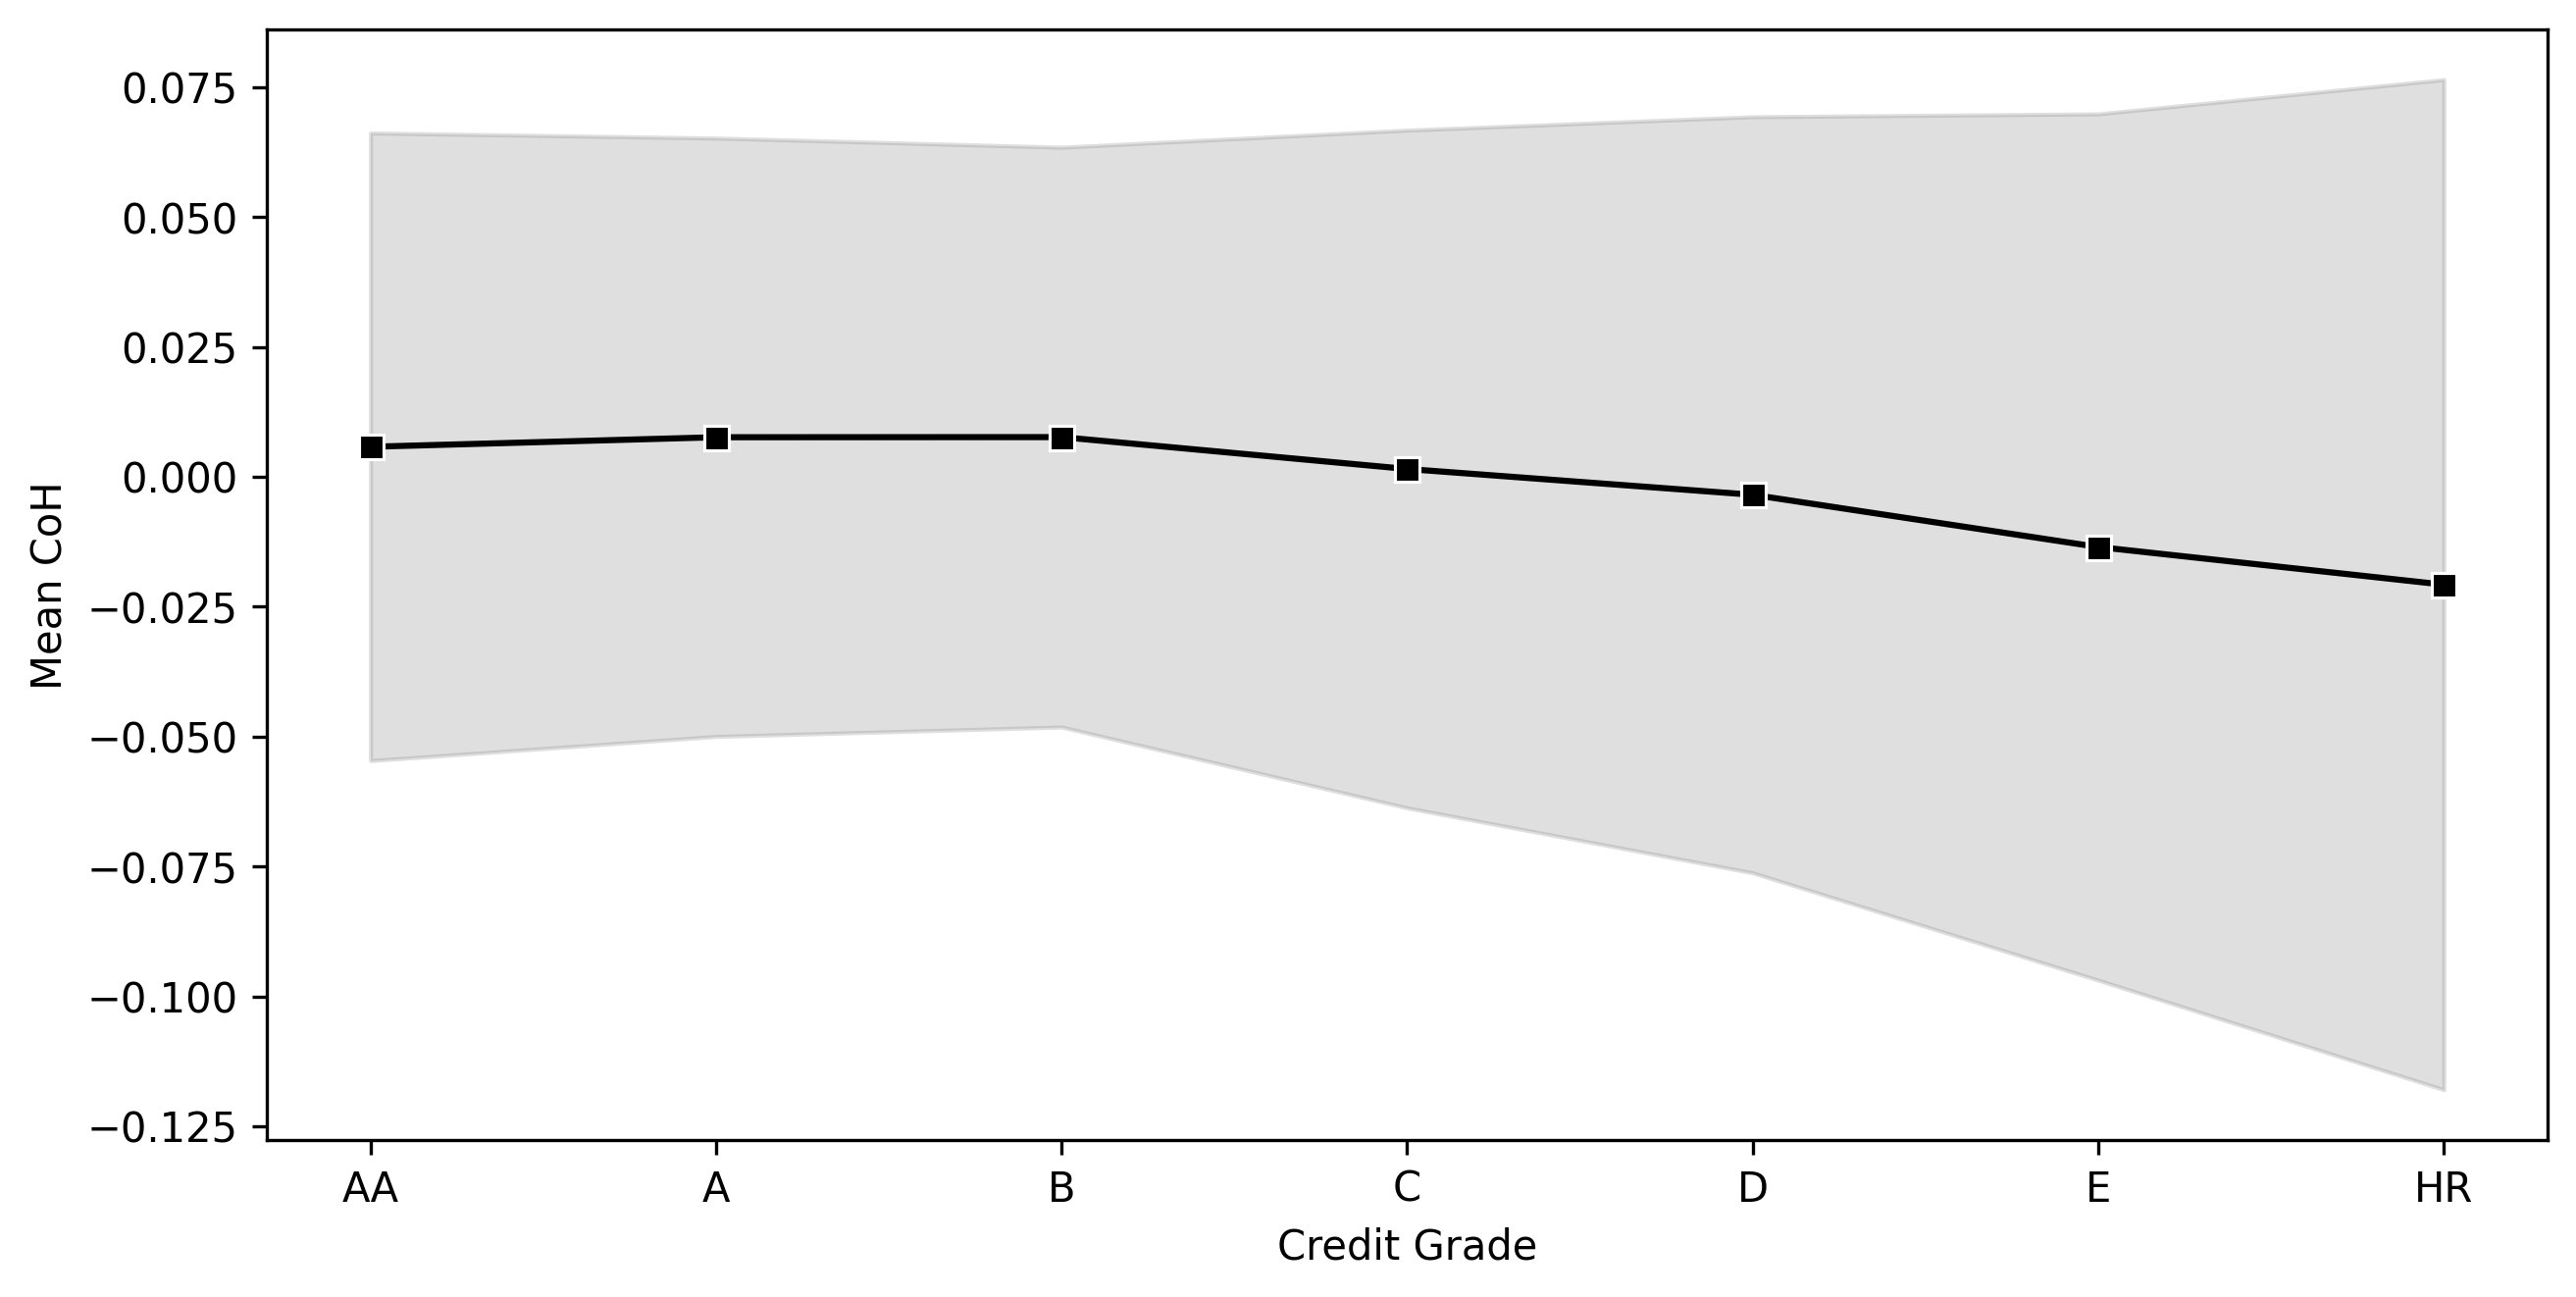

In [78]:
plt.figure(figsize=(10,5), dpi=300)
g = sns.lineplot(x='CreditGrade', y=('CoH5', 'mean'), marker='s', data=mv_table, color='k',  legend=False)
plt.fill_between(mv_table['CreditGrade'], 
                mv_table[('CoH5', 'mean')]-mv_table[('CoH5', 'std')], 
                mv_table[('CoH5', 'mean')]+mv_table[('CoH5', 'std')], 
                color='grey', alpha=.25)
plt.xticks(range(7), credit_grades)
plt.ylabel('Mean CoH')
plt.xlabel('Credit Grade')
plt.show(g)


### Momentum

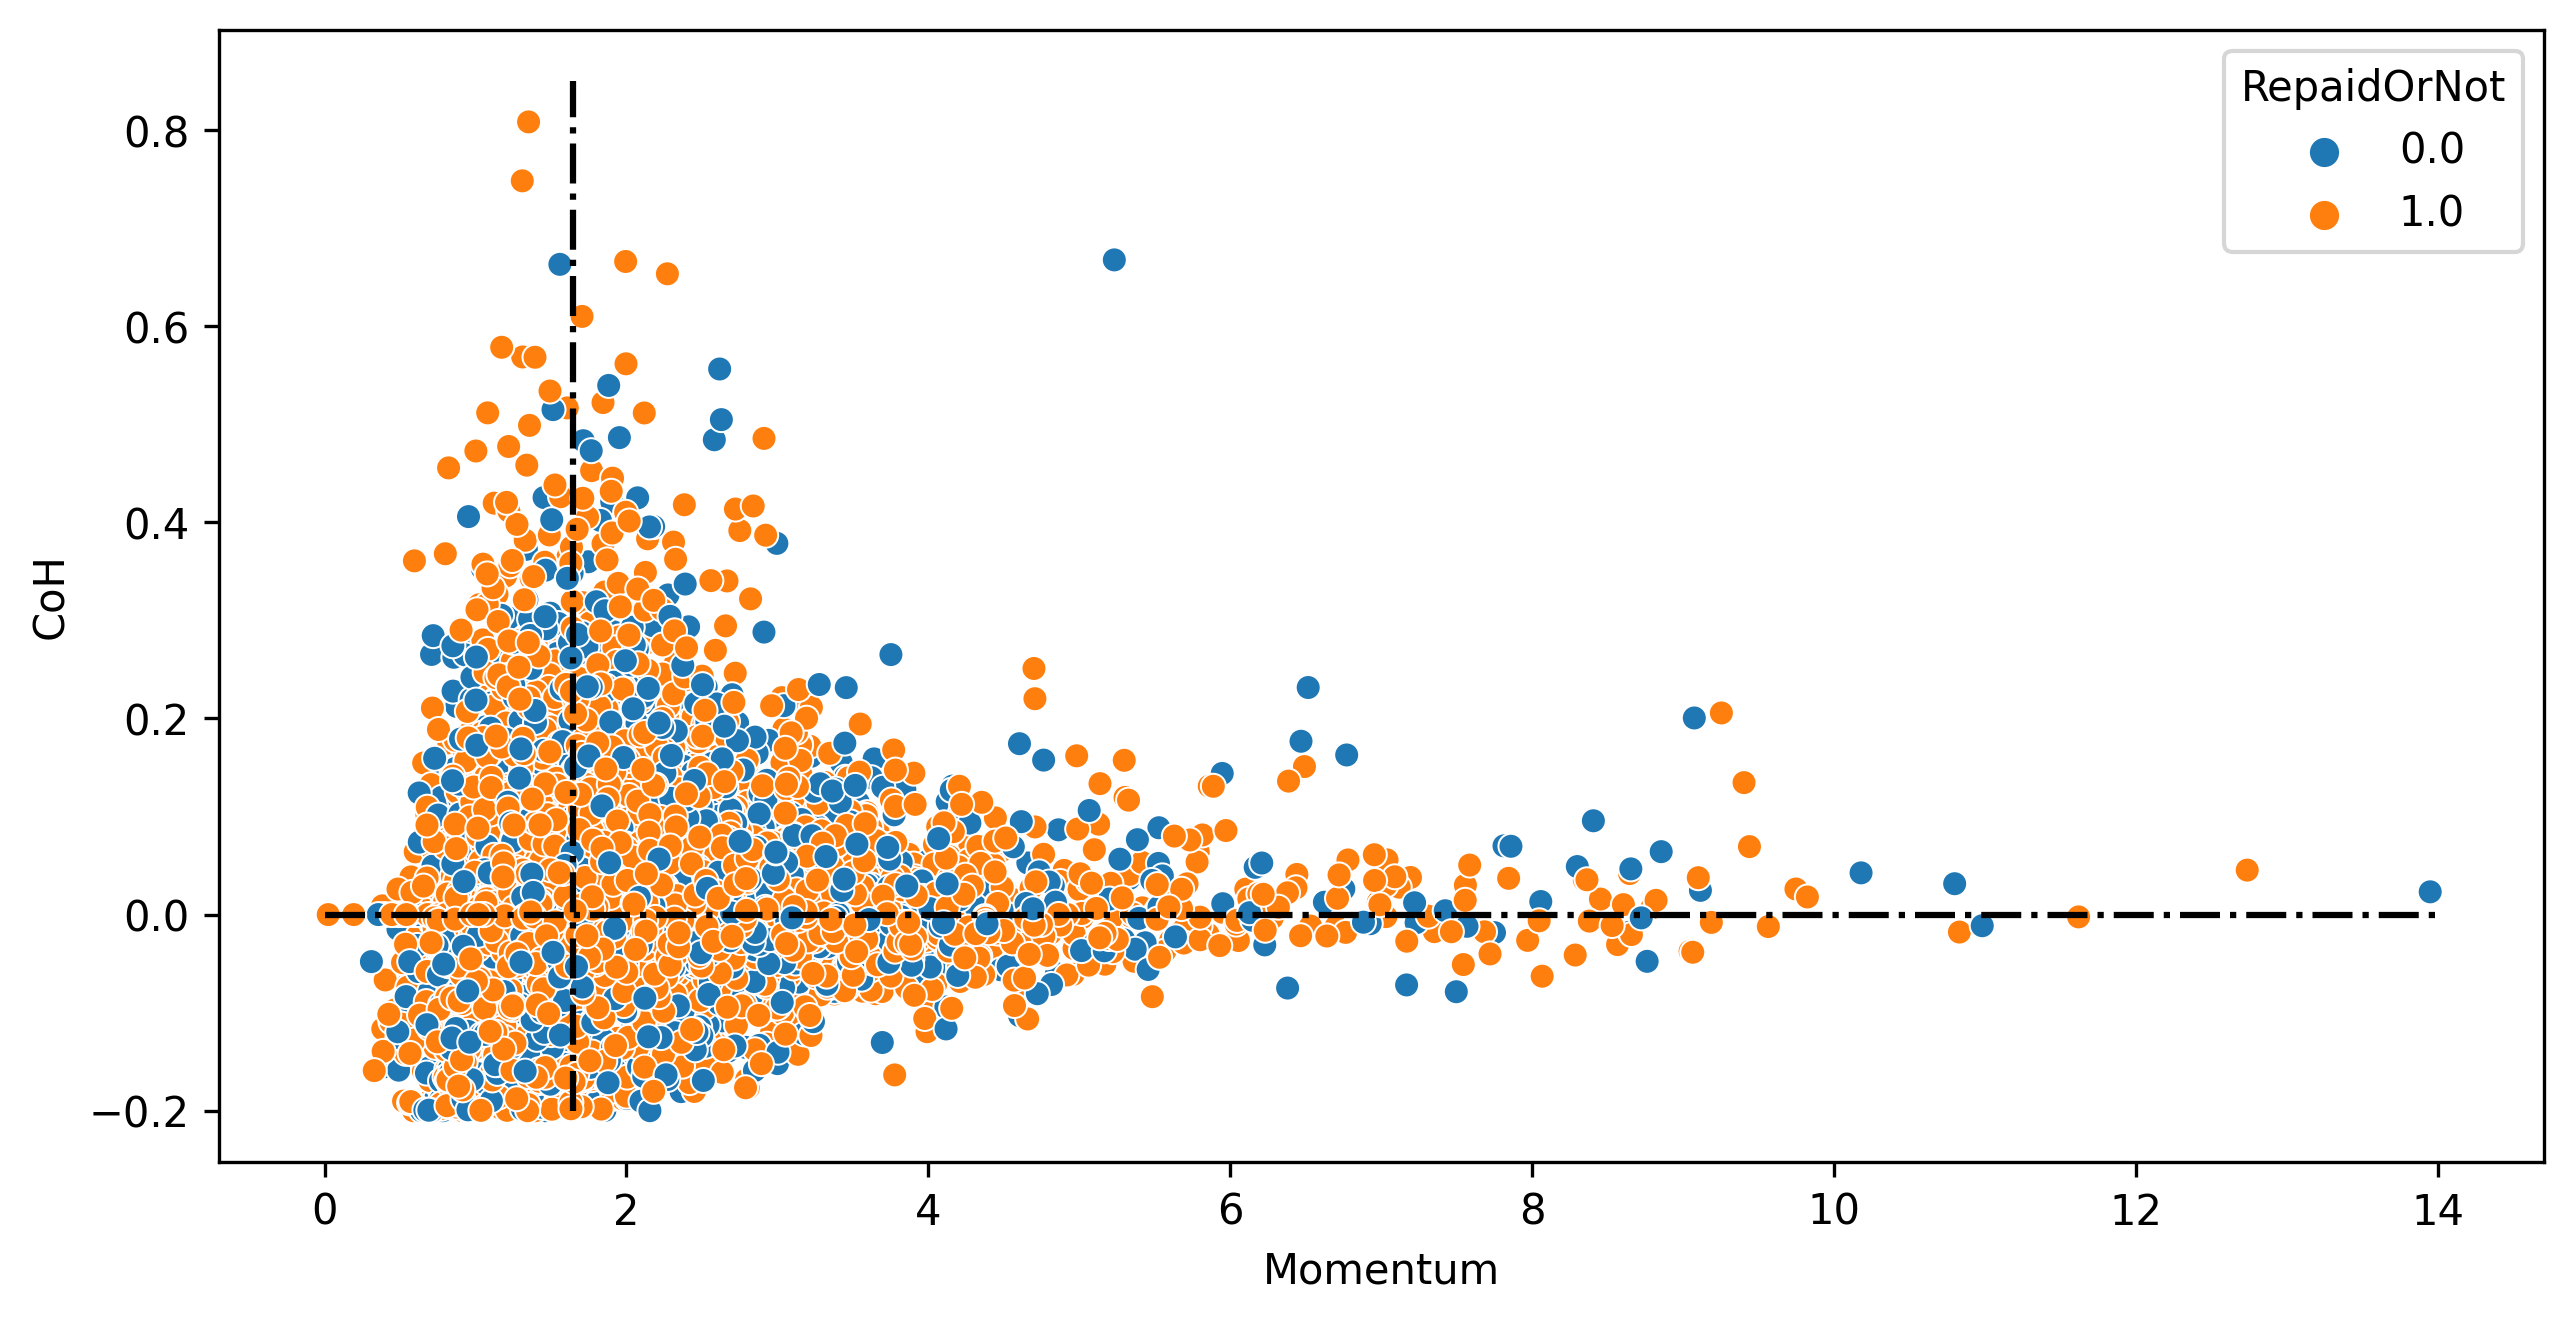

In [111]:
plt.figure(figsize=(10,5), dpi=300)
g = sns.scatterplot(x='Momentum', y='CoH5', data=data[data.Momentum!=0], hue='RepaidOrNot', legend=True)
plt.hlines(0,0,14, color='k', linestyle='-.')
plt.vlines(data.Momentum.mean(),-0.2,0.85, color='k', linestyle='-.')
plt.ylabel('CoH')
plt.xlabel('Momentum')
plt.show(g)

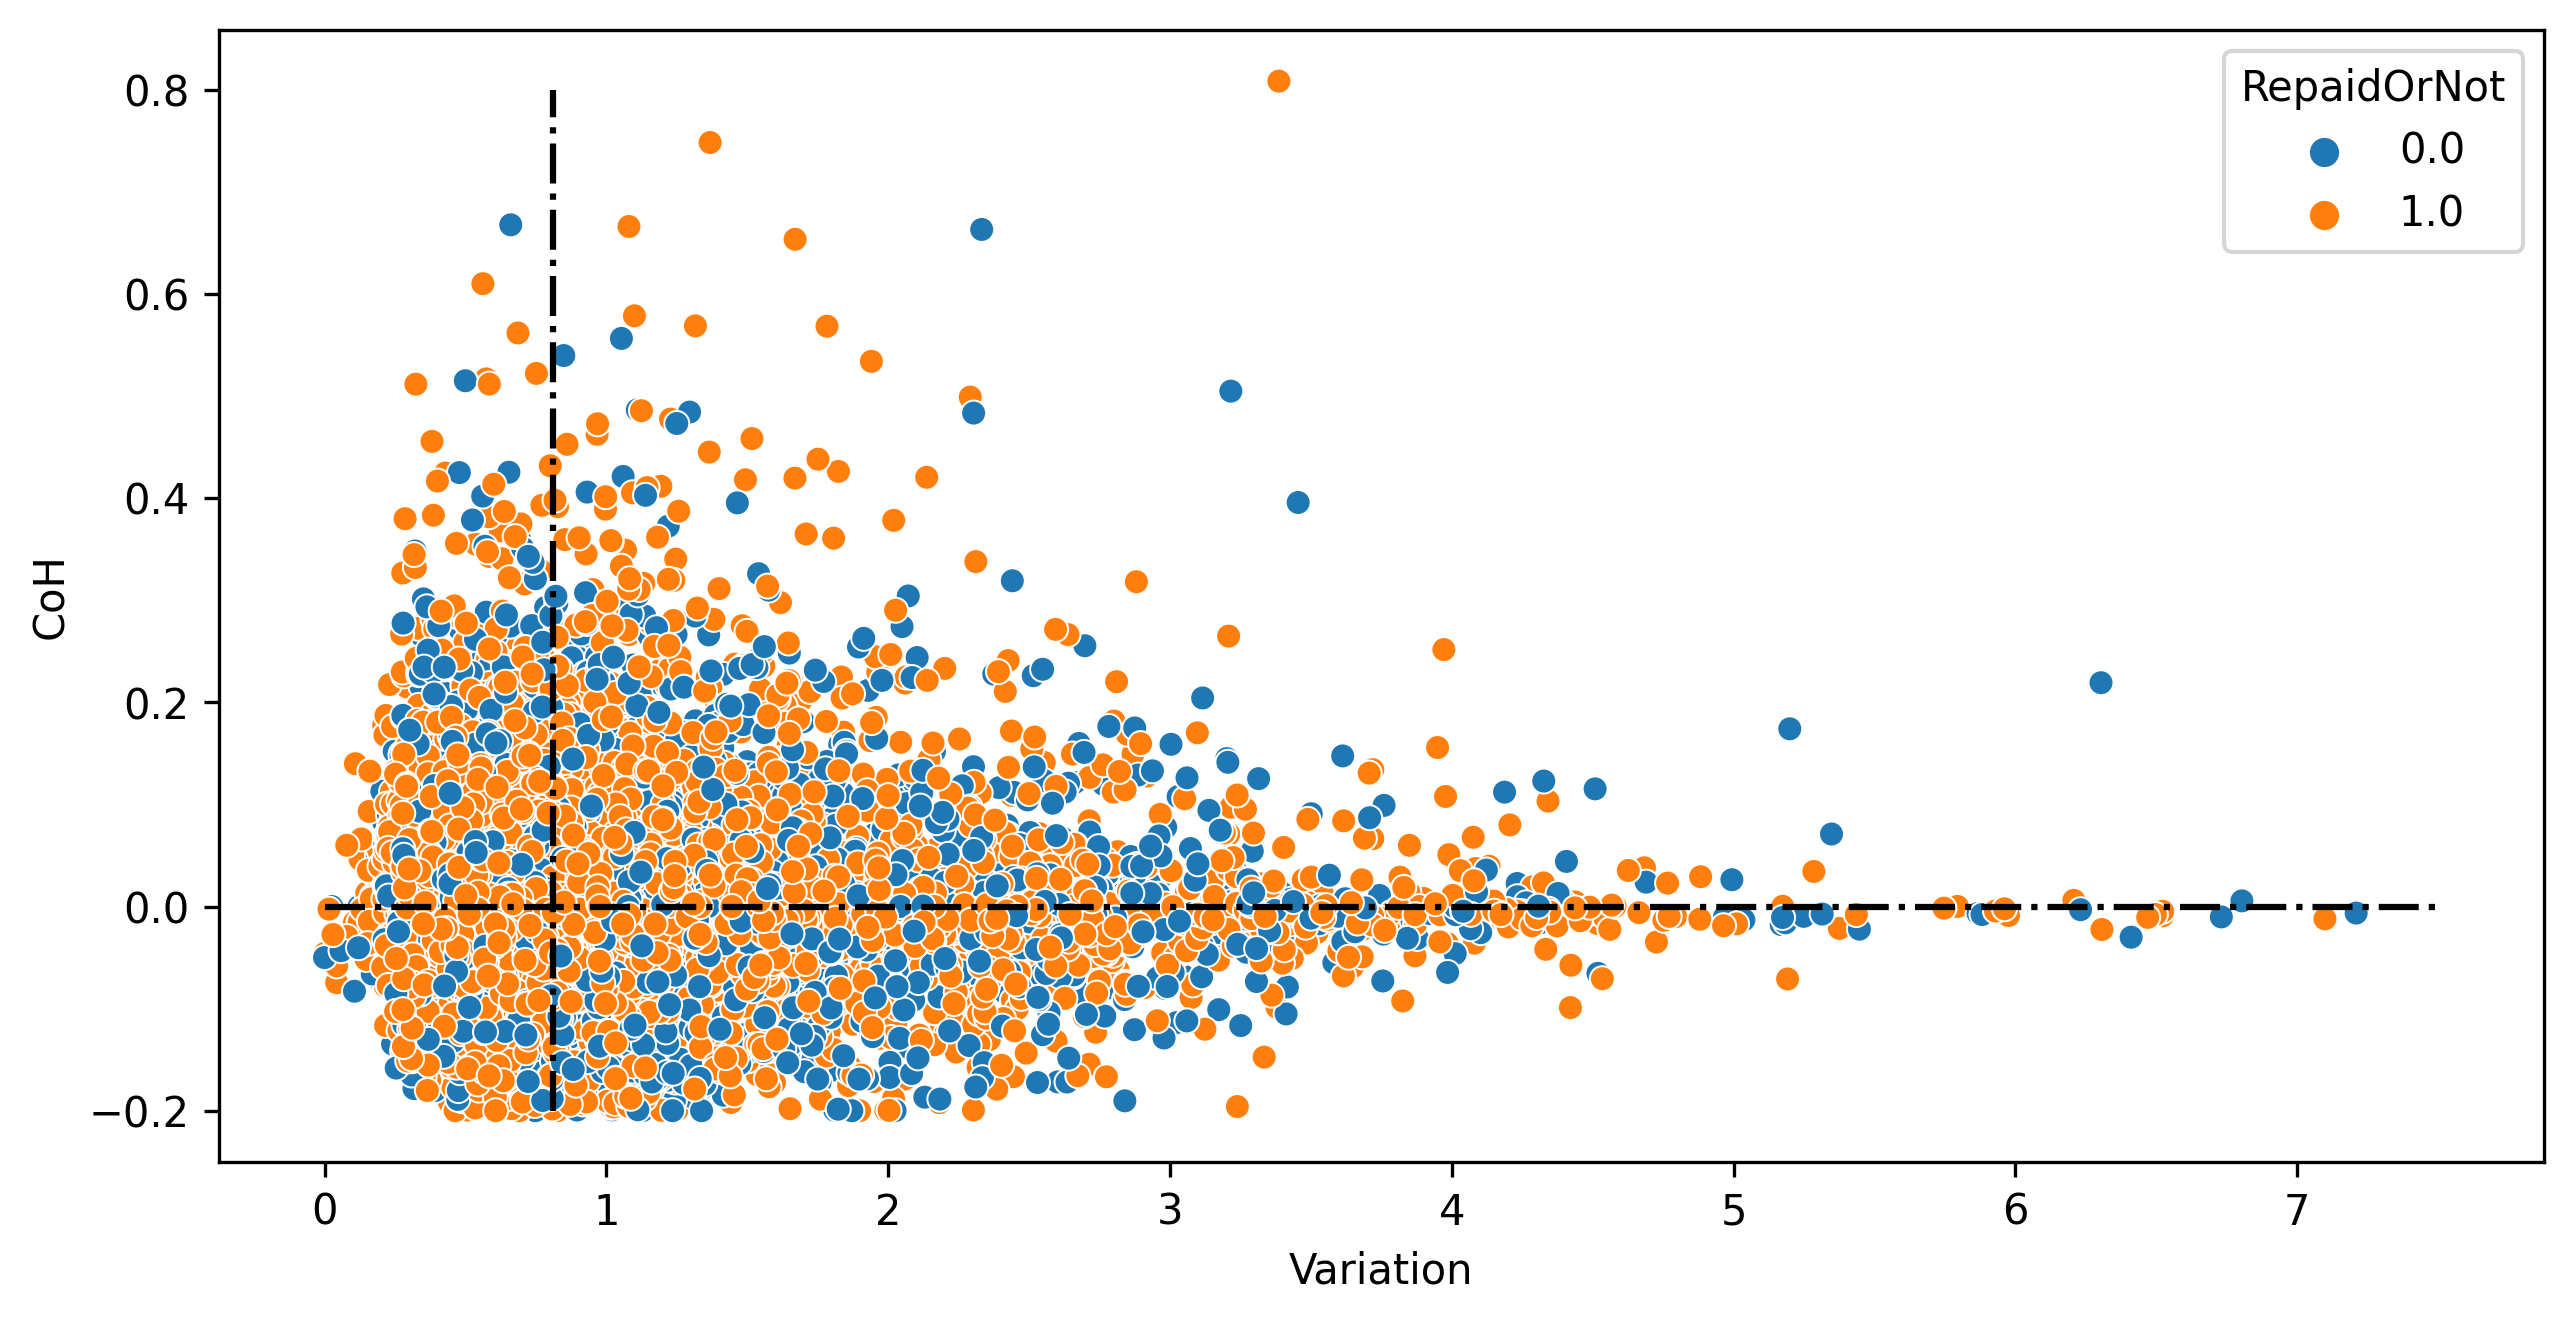

In [107]:
plt.figure(figsize=(10,5), dpi=300)
g = sns.scatterplot(x='Variation', y='CoH5', data=data[data.Variation!=0], hue='RepaidOrNot', legend=True)
plt.hlines(0,0,7.5, color='k', linestyle='-.')
plt.vlines(data.Variation.mean(),-0.2,0.8, color='k', linestyle='-.')
plt.ylabel('CoH')
plt.xlabel('Variation')
plt.show(g)

### Defaulted

In [113]:
credit_grade_outcomes = data[['CreditGrade', 'RepaidOrNot']].groupby('CreditGrade').agg(['count','sum']).reset_index()
credit_grade_outcomes['% Defaulted'] = (1 - (credit_grade_outcomes[ ('RepaidOrNot',   'sum')] / credit_grade_outcomes[('RepaidOrNot', 'count')]) ) * 100
credit_grade_outcomes['CreditGrade'] = credit_grade_outcomes['CreditGrade'].astype(int)
credit_grade_outcomes = credit_grade_outcomes.replace({"CreditGrade": {value:key for key, value in creditmap.items()}}) 
credit_grade_outcomes = credit_grade_outcomes.sort_values(by='CreditGrade')[1:8]
credit_grade_outcomes = credit_grade_outcomes.drop('RepaidOrNot', axis=1)
credit_grade_outcomes

,CreditGrade,% Defaulted
,,
8,AA,15.400
7,AB,24.536
6,B,32.108
5,C,36.311
4,D,39.729
3,E,49.192
2,HR,61.825


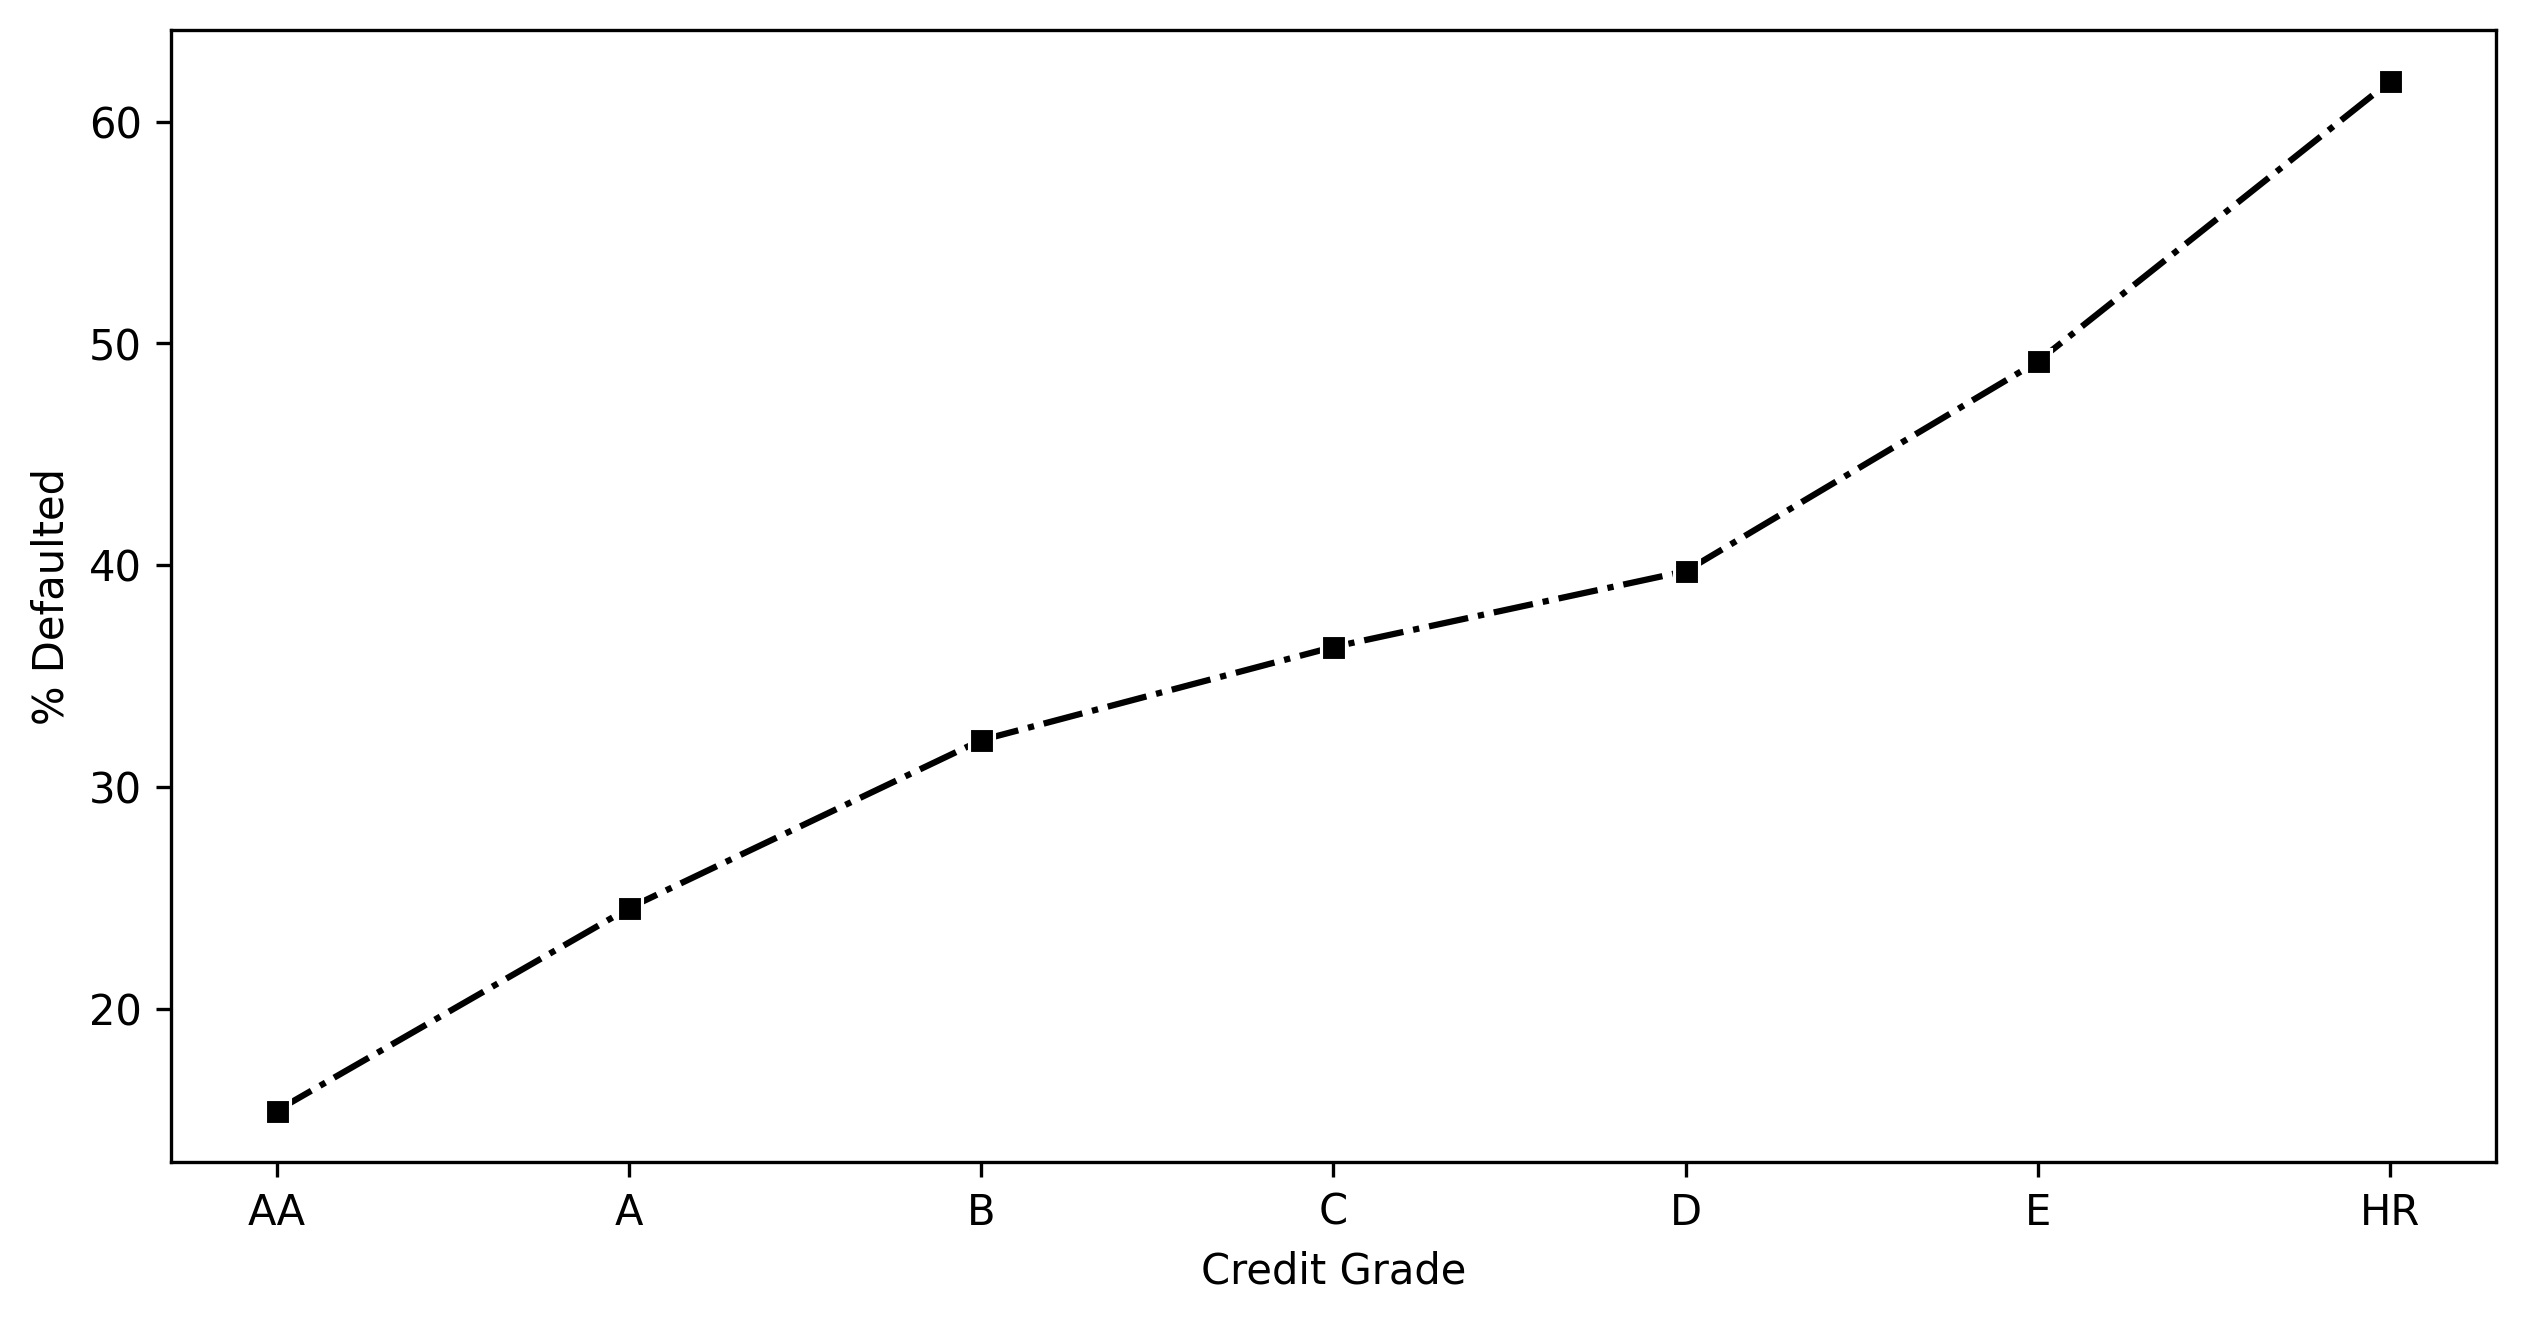

In [117]:
plt.figure(figsize=(10,5), dpi=300)
g = sns.lineplot(x='CreditGrade', y='% Defaulted', data=credit_grade_outcomes, linestyle='-.', marker='s', color='k', legend=False)
plt.xticks(range(7), credit_grades)
plt.ylabel('% Defaulted')
plt.xlabel('Credit Grade')
plt.show(g)

## Feature Correlations

In [15]:
corr = data.corr()
corr

,AmountRequested,NumBids,AvgBid,Momentum,Variation,CoH1,CoH3,CoH5,ProsperScore,CreditGrade,DebtRatio,Homeowner,Description,Category,RepaidOrNot
AmountRequested,1.000,0.799,0.086,0.488,0.448,-0.119,-0.094,-0.098,0.097,0.552,0.118,0.326,0.244,0.024,0.133
NumBids,0.799,1.000,-0.065,0.500,0.238,-0.204,-0.172,-0.176,0.246,0.543,0.072,0.326,0.229,0.098,0.188
AvgBid,0.086,-0.065,1.000,-0.103,-0.001,0.557,0.533,0.487,-0.041,0.016,0.027,-0.016,0.027,0.001,0.042
Momentum,0.488,0.500,-0.103,1.000,0.353,-0.246,-0.238,-0.243,0.352,0.590,0.099,0.298,0.339,0.229,0.298
Variation,0.448,0.238,-0.001,0.353,1.000,-0.097,-0.083,-0.055,0.058,0.408,0.117,0.196,0.324,0.055,0.196
CoH1,-0.119,-0.204,0.557,-0.246,-0.097,1.000,0.860,0.779,-0.104,-0.130,0.014,-0.088,-0.005,-0.014,-0.012
CoH3,-0.094,-0.172,0.533,-0.238,-0.083,0.860,1.000,0.860,-0.093,-0.119,0.004,-0.075,-0.003,-0.006,-0.011
CoH5,-0.098,-0.176,0.487,-0.243,-0.055,0.779,0.860,1.000,-0.102,-0.127,0.001,-0.080,-0.005,-0.005,-0.016
ProsperScore,0.097,0.246,-0.041,0.352,0.058,-0.104,-0.093,-0.102,1.000,0.502,0.029,0.217,0.061,0.457,0.349
CreditGrade,0.552,0.543,0.016,0.590,0.408,-0.130,-0.119,-0.127,0.502,1.000,0.105,0.423,0.221,0.259,0.488


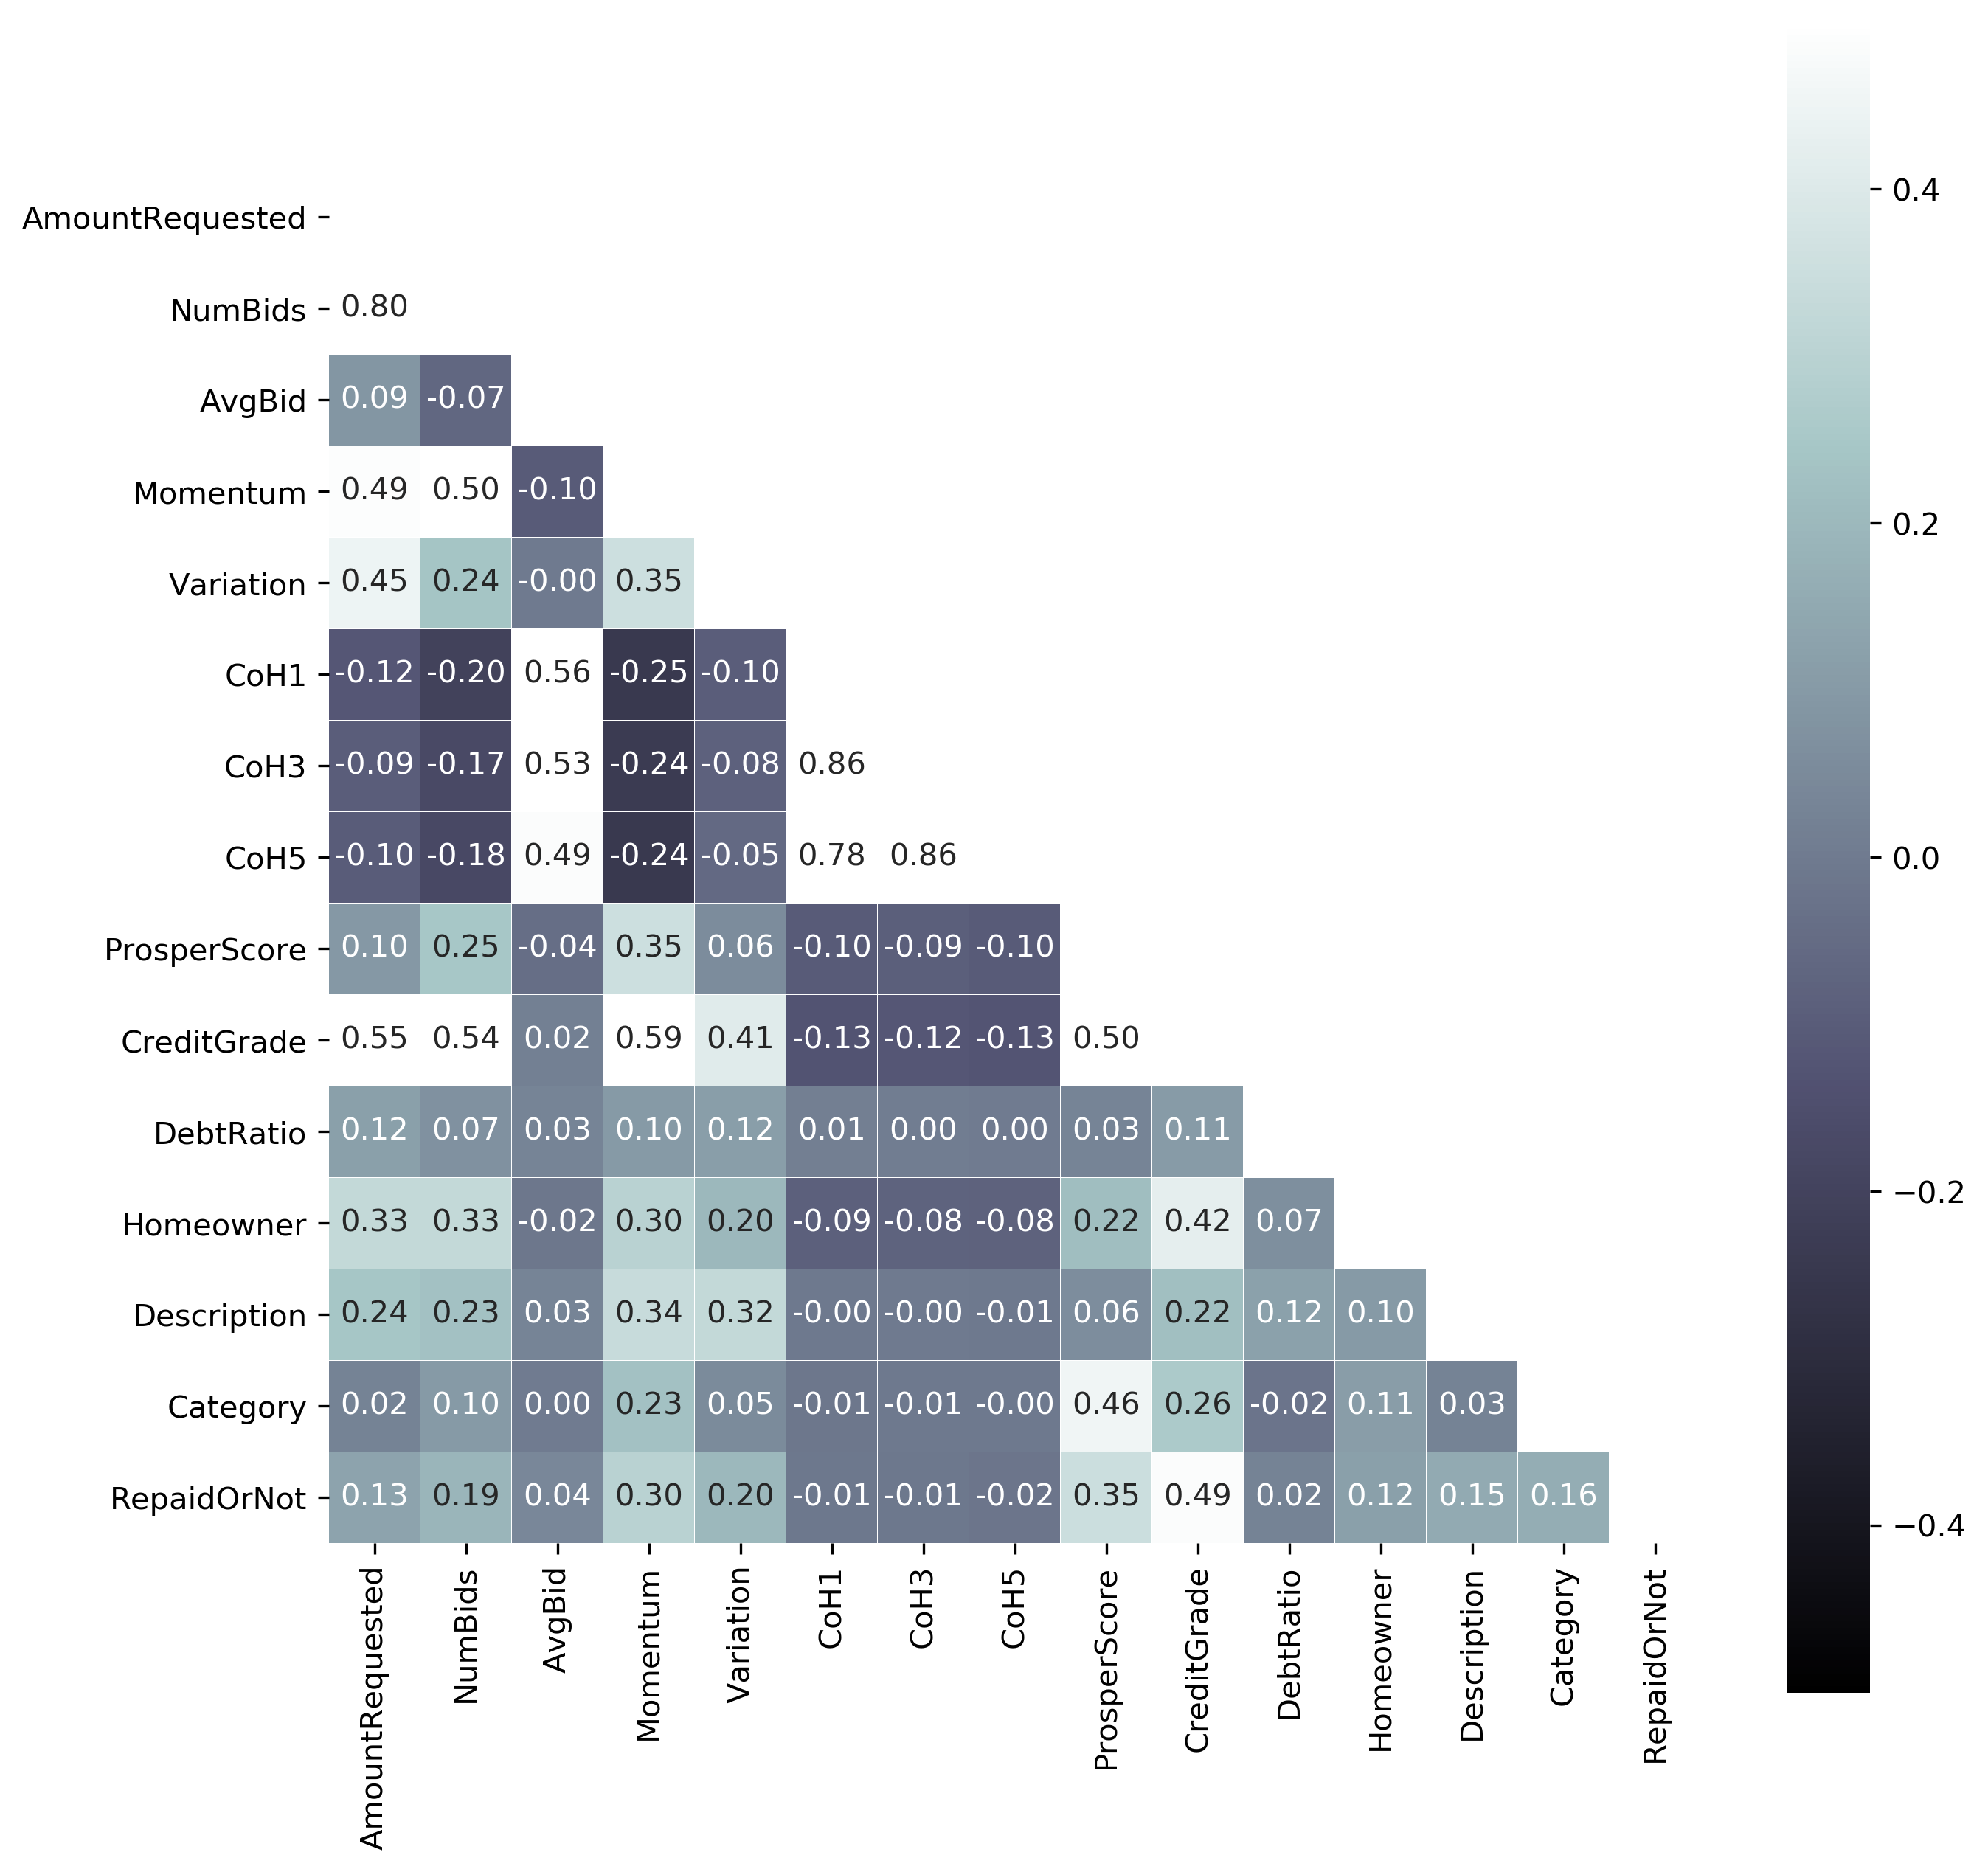

In [16]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10,10), dpi=300)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(corr, mask=mask, linewidths=0.1,vmax=.5, vmin=-.5, 
            square=True, cmap='bone', linecolor='white', annot=True, fmt='.2f')

In [121]:
result0 = stats.pearsonr(data[coh].fillna(0), data['AvgBid'].fillna(0))
print ("Positive correlation between herding and average bid value (r={}, p<{}01).".format(round(result0[0],2), result0[1]))


Positive correlation between average bid value and herding (r=0.49, p<0.001).


In [124]:
result1 = stats.pearsonr(data[coh].fillna(0), data['Momentum'].fillna(0))
print ("Negative correlation between herding and momentum (r={}, p<{}01).".format(round(result1[0],2), result1[1]))


Negative correlation between herding and momentum (r=-0.24, p<0.001).


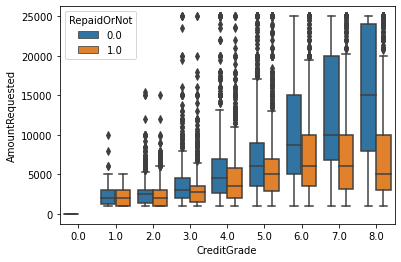

In [117]:
sns.boxplot(x='CreditGrade', y='AmountRequested', hue='RepaidOrNot', data=data);